# Analysis functions

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utilities import time_to_seconds, get_triplicates_jackknife, get_endpoint, get_initial
from src.modeling import model_one_step, residuals, fit_model
from src.statistics import wald_z, holm_correction, prop_err_division
#Standardized color scheme for plotting
color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Importing data

In [26]:
data_path = './Data/'

UW_controls = pd.read_csv(data_path + 'UW_Cascades.csv')
conditions_UW_controls = {'R alone' : ['B10', 'C10', 'D10'], #actually cascade alone
                          'R(nn) alone' : ['E10', 'F10', 'G10']}
offset_UW_controls = 0
t_UW_controls = [time_to_seconds(t) for t in UW_controls['Time'].values]

UW_casc_controls = pd.read_csv(data_path + 'UW_Cascades.csv')
conditions_UW_casc_controls = {'Cascade' : ['B5', 'C5', 'D5'],
                                'Cascade(nn)' : ['E5', 'F5', 'G5']}
offset_UW_casc_controls = 0
t_UW_casc_controls = [time_to_seconds(t) for t in UW_casc_controls['Time'].values]


UW_trig = pd.read_csv(data_path + 'UW_Cascades.csv')
conditions_UW_trig = {'N50_25uM nat' : ['B9', 'C9', 'D9'],
                      'N50_25uM nn' : ['E9', 'F9', 'G9']}
offset_UW_trig = 190
t_UW_trig = [time_to_seconds(t) for t in UW_trig['Time'].values]


UW_casc = pd.read_csv(data_path + 'UW_Cascades.csv')
conditions_UW_casc = {'N50_25uM nat' : ['B8', 'C8', 'D8'],
                     'N50_25uM nn' : ['E8', 'F8', 'G8']}
offset_UW_casc = 190
t_UW_casc = [time_to_seconds(t) for t in UW_casc['Time'].values]


UW_no = pd.read_csv(data_path + 'UW_Cascades.csv')

conditions_UW_no = {'N50_25uM nat' : ['B13', 'C13', 'D13'],
             'N50_25uM nn' : ['E13', 'F13', 'G13']}
offset_UW_no = 190
t_UW_no = [time_to_seconds(t) for t in UW_no['Time'].values]



TUM_controls = pd.read_csv(data_path + 'TUM_Controls.csv')
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) for t in TUM_controls['time'].values]

TUM_casc_controls = pd.read_csv(data_path + 'TUM_Cascades_NoIncub.csv')
conditions_TUM_casc_controls = {'Cascade' : ['Cascade_1',	'Cascade_2',	'Cascade_3'],
                                'Cascade(nn)' : ['Cascade(nn)_1',	'Cascade(nn)_2',	'Cascade(nn)_3']}
offset_TUM_casc_controls = 0
t_TUM_casc_controls = [int(t) for t in TUM_casc_controls['time'].values]


TUM_no = pd.read_csv(data_path + 'TUM_Cascades_NoIncub.csv')
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) for t in TUM_no['time'].values]


TUM_trig = pd.read_csv(data_path + 'TUM_Cascades_TrigIncub.csv')
conditions_TUM_trig = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_trig = 0
t_TUM_trig = [int(t) for t in TUM_trig['time'].values]


TUM_casc = pd.read_csv(data_path + 'TUM_Cascades_CascIncub.csv')
conditions_TUM_casc = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                       'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                       'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                       'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                       'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                       'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                       'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                       'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                        'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                        'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                        }
offset_TUM_casc = 0
t_TUM_casc = [int(t) for t in TUM_casc['time'].values]


number_of_points = 6*3600//60

# Processing TUM data

In [27]:
t1 = t_TUM_controls
data1 = TUM_controls
conditions1 = conditions_TUM_controls
t2 = t_TUM_casc_controls
data2 = TUM_casc_controls
conditions2 = conditions_TUM_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i, level in enumerate(levels1):
    dfArray.append(get_endpoint(level, t1, data1, conditions1))
for i, level in enumerate(levels2):
    dfArray.append(get_endpoint(level, t2, data2, conditions2))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,buffer alone,3965.7,3840.1,3885.0,3896.933333,51.965651
1,R alone,4015.6,4016.1,3856.7,3962.800000,75.024307
2,R(nn) alone,4008.1,4251.2,3970.7,4076.666667,124.354609
3,Cascade,16789.3,17054.0,16423.0,16755.433333,258.715369
4,Cascade(nn),16496.0,15884.3,16110.8,16163.700000,252.511425


In [28]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]

## Controls

Fitted kf = 5.4e+03 ± 4.0e+02 (jackknife SE, n=3)
RMSE = 4.324e-10
nRMSE (normed by mean)  = 0.030


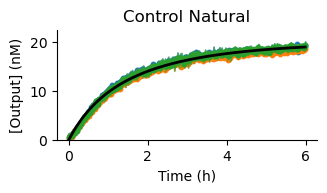

In [31]:
t = t_TUM_casc_controls[0:number_of_points]
data = TUM_casc_controls[0:number_of_points]
conditions = conditions_TUM_casc_controls
levels = [list(conditions.keys())[0]]
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]

# Perform jackknife fitting
res = []
for curve in to_fit[0]:
  res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nat = [[kf_mean, kf_se]]
fitted_kf = k_control_nat[0][0]


# Plotting results
fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_th,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_th,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_th,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)

# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")


ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


plt.savefig("Figures/TUM_casc_control_nat.svg", dpi=400)
plt.show()



Fitted kf = 1.0e+04 ± 5.8e+02 (jackknife SE, n=3)
RMSE = 1.381e-09
nRMSE (normed by mean)  = 0.086


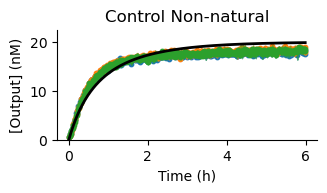

In [32]:
t = t_TUM_casc_controls[0:number_of_points]
data = TUM_casc_controls[0:number_of_points]
conditions = conditions_TUM_casc_controls
levels = [list(conditions.keys())[1]]
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for level in levels:
    curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
    stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]
#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]

# Perform jackknife fitting
res = []
for curve in to_fit[0]:
  res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]

res = np.array(res, dtype=float)
n = len(res)
kf_mean = res.mean()

# JACKKNIFE SE: sqrt((n-1)/n * sum (θ_i - θ_bar)^2)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE, n={n})")

k_control_nn = [[kf_mean, kf_se]]
fitted_kf = k_control_nn[0][0]


# Plotting results
fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_th,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_th,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_th,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)

# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")


ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

plt.savefig("Figures/TUM_casc_control_nn.svg", dpi=400)

plt.show()



## With Background

### No incubation

#### nat

Condition: 10μM_N25
Fitted kf = 1.5e+03 ± 4.3e+01 (jackknife SE)
RMSE = 2.543e-10
nRMSE (normed by mean)  = 0.032

Condition: 25μM_N25
Fitted kf = 6.2e+02 ± 1.6e+01 (jackknife SE)
RMSE = 2.177e-10
nRMSE (normed by mean)  = 0.052

Condition: 10μM_N50
Fitted kf = 2.0e+02 ± 9.0e+00 (jackknife SE)
RMSE = 2.376e-10
nRMSE (normed by mean)  = 0.144

Condition: 25μM_N50
Fitted kf = 5.9e+01 ± 4.9e+00 (jackknife SE)
RMSE = 1.961e-10
nRMSE (normed by mean)  = 0.350



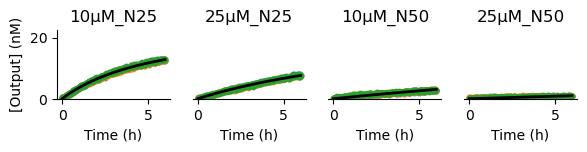

In [33]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]


#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]*4



# Plotting results
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nat = []
for i,a in enumerate(ax):
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))
    print(f"Condition: {labels[i]}")
    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
   
   
    # Calculating mean normalized RMSE for each condition
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, model_one_step, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}\n")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_casc_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



Condition: 10μM_N25
Fitted kf = 4.8e+03 ± 2.3e+02 (jackknife SE)
RMSE = 8.774e-10
nRMSE (normed by mean)  = 0.064

Condition: 25μM_N25
Fitted kf = 2.5e+03 ± 1.4e+02 (jackknife SE)
RMSE = 4.716e-10
nRMSE (normed by mean)  = 0.045

Condition: 10μM_N50
Fitted kf = 8.7e+02 ± 8.2e+01 (jackknife SE)
RMSE = 5.226e-10
nRMSE (normed by mean)  = 0.094

Condition: 25μM_N50
Fitted kf = 2.3e+02 ± 1.1e+01 (jackknife SE)
RMSE = 1.854e-10
nRMSE (normed by mean)  = 0.103



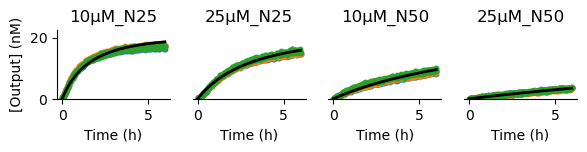

In [34]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]


#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]*4



# Plotting results
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_no_nn = []
for i,a in enumerate(ax):
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)
    

    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))
    print(f"Condition: {labels[i]}")
    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_no_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
   
   
    # Calculating mean normalized RMSE for each condition
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, model_one_step, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}\n")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_casc_nn_noinc.svg', dpi = 500, transparent=True)
plt.show()



## Trigger incubation

Condition: 10μM_N25
Fitted kf = 9.5e+02 ± 4.0e+01 (jackknife SE)
RMSE = 2.659e-10
nRMSE (normed by mean)  = 0.045

Condition: 25μM_N25
Fitted kf = 4.0e+02 ± 1.2e+01 (jackknife SE)
RMSE = 2.263e-10
nRMSE (normed by mean)  = 0.075

Condition: 10μM_N50
Fitted kf = 1.3e+02 ± 6.8e+00 (jackknife SE)
RMSE = 2.881e-10
nRMSE (normed by mean)  = 0.247

Condition: 25μM_N50
Fitted kf = 6.4e+01 ± 3.4e+00 (jackknife SE)
RMSE = 3.032e-10
nRMSE (normed by mean)  = 0.457



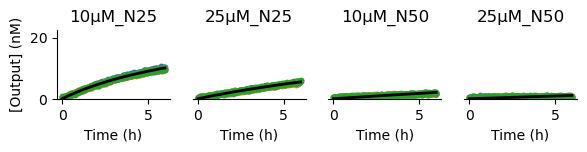

In [35]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]


#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]*4



# Plotting results
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nat = []
for i,a in enumerate(ax):
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))
    print(f"Condition: {labels[i]}")
    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_trig_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
   
   
    # Calculating mean normalized RMSE for each condition
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, model_one_step, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}\n")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_casc_nat_trig.svg', dpi = 500, transparent=True)
plt.show()



Condition: 10μM_N25
Fitted kf = 3.8e+03 ± 1.4e+02 (jackknife SE)
RMSE = 8.470e-10
nRMSE (normed by mean)  = 0.067

Condition: 25μM_N25
Fitted kf = 1.9e+03 ± 5.4e+01 (jackknife SE)
RMSE = 3.393e-10
nRMSE (normed by mean)  = 0.037

Condition: 10μM_N50
Fitted kf = 7.7e+02 ± 2.0e+01 (jackknife SE)
RMSE = 3.337e-10
nRMSE (normed by mean)  = 0.065

Condition: 25μM_N50
Fitted kf = 2.6e+02 ± 4.0e+00 (jackknife SE)
RMSE = 4.637e-10
nRMSE (normed by mean)  = 0.207



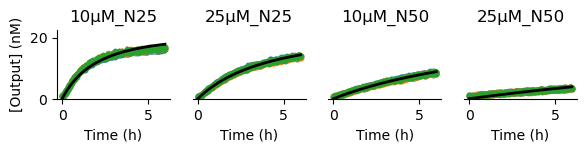

In [36]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_trig[0:number_of_points]
conditions = conditions_TUM_trig
levels = list(conditions.keys())
offset = offset_TUM_trig
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]


#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]*4



# Plotting results
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_trig_nn = []
for i,a in enumerate(ax):
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))
    print(f"Condition: {labels[i]}")
    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    k_trig_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
   
   
    # Calculating mean normalized RMSE for each condition
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, model_one_step, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}\n")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_casc_nn_trig.svg', dpi = 500, transparent=True)
plt.show()



## Reporter incubation

Condition: 10μM_N25
Fitted kf = 1.4e+03 ± 8.3e+01 (jackknife SE)
RMSE = 3.420e-10
nRMSE (normed by mean)  = 0.046

Condition: 25μM_N25
Fitted kf = 6.0e+02 ± 6.5e+00 (jackknife SE)
RMSE = 2.053e-10
nRMSE (normed by mean)  = 0.050

Condition: 10μM_N50
Fitted kf = 1.6e+02 ± 9.9e+00 (jackknife SE)
RMSE = 2.235e-10
nRMSE (normed by mean)  = 0.163

Condition: 25μM_N50
Fitted kf = 3.3e+01 ± 2.9e+00 (jackknife SE)
RMSE = 1.567e-10
nRMSE (normed by mean)  = 0.549



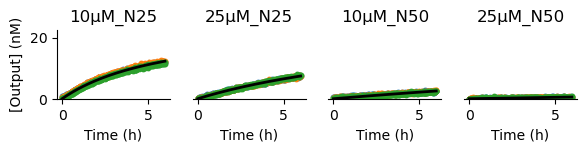

In [37]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_casc[0:number_of_points]
conditions = conditions_TUM_casc
levels = list(conditions.keys())
offset = offset_TUM_casc
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0, 1, 2, 3]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]


#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]*4



# Plotting results
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nat = []
for i,a in enumerate(ax):
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))
    print(f"Condition: {labels[i]}")
    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_rep_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
   
   
    # Calculating mean normalized RMSE for each condition
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, model_one_step, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}\n")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_casc_nat_rep.svg', dpi = 500, transparent=True)
plt.show()



Condition: 10μM_N25
Fitted kf = 3.0e+03 ± 1.4e+02 (jackknife SE)
RMSE = 1.068e-09
nRMSE (normed by mean)  = 0.093

Condition: 25μM_N25
Fitted kf = 1.9e+03 ± 9.6e+01 (jackknife SE)
RMSE = 5.541e-10
nRMSE (normed by mean)  = 0.060

Condition: 10μM_N50
Fitted kf = 8.3e+02 ± 2.6e+01 (jackknife SE)
RMSE = 2.629e-10
nRMSE (normed by mean)  = 0.050

Condition: 25μM_N50
Fitted kf = 2.2e+02 ± 1.4e+00 (jackknife SE)
RMSE = 1.851e-10
nRMSE (normed by mean)  = 0.105



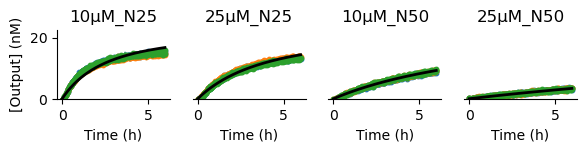

In [38]:
labels = [u"10\u03bcM_N25", u"25\u03bcM_N25", u"10\u03bcM_N50", u"25\u03bcM_N50"]

data = TUM_casc[0:number_of_points]
conditions = conditions_TUM_casc
levels = list(conditions.keys())
offset = offset_TUM_casc
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [4, 5, 6, 7]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]


# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]


#Reporter concentration in nM
scale = 40 


fixed_params_list = [
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale},
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1


#List of time series for fitting
x_list  = [x_trunc]*4



# Plotting results
fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

k_rep_nn = []
for i,a in enumerate(ax):
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_th,c, color=color_scheme[j], s = 10)
        a.fill_between(x_th,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_th,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    res = np.array(res).flatten()
    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))
    print(f"Condition: {labels[i]}")
    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


  
    k_rep_nn.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)
   
   
    # Calculating mean normalized RMSE for each condition
    nrep = len(to_fit[i])
    t_i = [x_trunc] * nrep
    fixed_i = [fixed_params_list[i]] * nrep   # replicate the dict for each curve
    r = residuals(kf_mean, model_one_step, t_i, to_fit[i], fixed_i)
    RMSE = np.sqrt(np.mean(r**2))
    y_all = np.concatenate(to_fit[i])
    nRMSE_mean  = RMSE / y_all.mean()
    print(f"RMSE = {RMSE:.3e}")
    print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}\n")

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

plt.savefig('Figures/TUM_casc_nn_rep.svg', dpi = 500, transparent=True)
plt.show()



# Analysis of TUM data alone

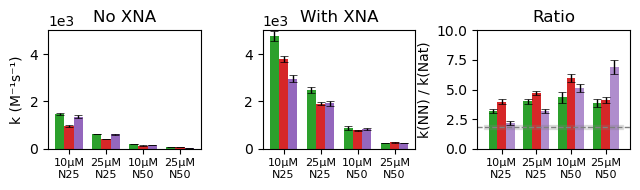


(1) Wald tests: Each bar vs control ratio comparison
10μM N25      No incubation    : ratio=3.210±0.179, Z= 5.419, p=5.981e-08, Holm=2.392e-07
10μM N25      Trigger incubated: ratio=3.975±0.218, Z= 7.595, p=3.086e-14, Holm=2.160e-13
10μM N25      Reporter incubated: ratio=2.175±0.167, Z= 1.321, p=1.866e-01, Holm=1.866e-01
25μM N25      No incubation    : ratio=3.987±0.246, Z= 7.070, p=1.545e-12, Holm=9.267e-12
25μM N25      Trigger incubated: ratio=4.717±0.192, Z=11.059, p=0.000e+00, Holm=0.000e+00
25μM N25      Reporter incubated: ratio=3.193±0.164, Z= 5.597, p=2.177e-08, Holm=1.089e-07
10μM N50      No incubation    : ratio=4.332±0.456, Z= 5.073, p=3.909e-07, Holm=1.173e-06
10μM N50      Trigger incubated: ratio=5.993±0.352, Z=10.547, p=0.000e+00, Holm=0.000e+00
10μM N50      Reporter incubated: ratio=5.108±0.350, Z= 8.316, p=0.000e+00, Holm=0.000e+00
25μM N50      No incubation    : ratio=3.867±0.367, Z= 4.947, p=7.519e-07, Holm=1.504e-06
25μM N50      Trigger incubated: ratio=4.12

In [39]:
#Consolidated bar plot of fitted k values
fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(2)


#Condition labels
labels = [u"10\u03bcM\nN25", 
          u"25\u03bcM\nN25", 
          u"10\u03bcM\nN50", 
          u"25\u03bcM\nN50"]
x = np.arange(len(labels))  # [0, 1, 2, 3]
bar_width = 0.25

# Data assembly
# Group datasets by color group
# Format (nat, nn, color, alpha)
datasets_panel0 = [
    (k_no_nat,   k_no_nn,   color_scheme[2], 1.0),
    (k_trig_nat, k_trig_nn, color_scheme[3], 1.0),
    (k_rep_nat,  k_rep_nn,  color_scheme[4], 1.0),
]

# Ratios k(NN)/k(Nat) + propagated errors for each background & incubation
k_no_diff = [[k_no_nn[i][0]   / k_no_nat[i][0],   prop_err_division(k_no_nn[i],   k_no_nat[i])]
             for i in range(len(k_no_nn))]
k_trig_diff = [[k_trig_nn[i][0] / k_trig_nat[i][0], prop_err_division(k_trig_nn[i], k_trig_nat[i])]
               for i in range(len(k_trig_nn))]
k_rep_diff = [[k_rep_nn[i][0]  / k_rep_nat[i][0],  prop_err_division(k_rep_nn[i],  k_rep_nat[i])]
              for i in range(len(k_rep_nn))]

datasets_panel1 = [
    (k_no_diff,   'No incubation',       color_scheme[2], 1.0),
    (k_trig_diff, 'Trigger incubated',   color_scheme[3], 1.0),
    (k_rep_diff,  'Reporter incubated',  color_scheme[4], 0.75),
]

error_params = dict(ecolor='black', lw=1, capsize=3, capthick=0.5)

# Plot nat and nn (panels 0 and 1)
for i, (nat_list, nn_list, color, scale) in enumerate(datasets_panel0):
    nat_y = [v[0] for v in nat_list]
    nat_err = [v[1] for v in nat_list]
    nn_y = [v[0] for v in nn_list]
    nn_err = [v[1] for v in nn_list]

    # x positions for this dataset
    dx = (i - 1) * bar_width  # shifts: -bar_width, 0, +bar_width
    ax[0].bar(x + dx, nat_y, width=bar_width, yerr=nat_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)
    ax[1].bar(x + dx, nn_y, width=bar_width, yerr=nn_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)

# Panel 2: draw ratio bars
for i, (diff_list, label, color, scale) in enumerate(datasets_panel1):
    diff_y = [v[0] for v in diff_list]
    diff_err = [v[1] for v in diff_list]
    dx = (i - 1) * bar_width  # shift left, center, right
    ax[2].bar(x + dx, diff_y, width=bar_width, yerr=diff_err, error_kw=error_params,
              color=color, label=label, alpha=scale)

# Control ratio line + band
control_ratio = k_control_nn[0][0] / k_control_nat[0][0]
control_ratio_se = prop_err_division(k_control_nn[0], k_control_nat[0])

ax[2].axhline(y=control_ratio, color='gray', linestyle='--', linewidth=1)
ax[2].fill_between(
    [-0.5, 3.5],
    [control_ratio - control_ratio_se] * 2,
    [control_ratio + control_ratio_se] * 2,
    color='gray', alpha=0.2,
)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=8)
    a.tick_params(axis='x', labelrotation=0)

ax[0].set_ylim(0,5000)
ax[1].set_ylim(0,5000)
ax[2].set_ylim(0, 10)

ax[0].set_ylabel('k (M⁻¹s⁻¹)', fontsize=10)
ax[2].set_ylabel('k(NN) / k(Nat)', fontsize=10)

# Set y-axis 0 and 1 to scientific notation
ax[0].yaxis.get_major_formatter().set_scientific(True)
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 1))
ax[1].yaxis.get_major_formatter().set_scientific(True)
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 1))

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

plt.tight_layout()
plt.savefig("Figures/NAR_casc_K.svg", dpi=400)
plt.show()




# Convenience: collect ratios by incubation type
# Each list is length 4 (one per background) with orde specified below
#  Each element if a list is  (ratio, se)
ratios_no   = k_no_diff
ratios_trig = k_trig_diff
ratios_rep  = k_rep_diff

backgrounds = [u"10\u03bcM N25", u"25\u03bcM N25", u"10\u03bcM N50", u"25\u03bcM N50"]
incubations = ["No incubation", "Trigger incubated", "Reporter incubated"]

# (1) Which bars differ from the control ratio?
#     (12 tests; Holm across all 12)
print("\n(1) Wald tests: Each bar vs control ratio comparison")

#
all_bar_results = []
pvals_bar = []
for i, bg in enumerate(backgrounds):
    for inc_label, (ratio_list, tag) in zip(
        incubations,
        [(ratios_no, 'No'),
         (ratios_trig, 'Trigger'),
         (ratios_rep, 'Reporter')]
    ):
        est, se = ratio_list[i]
        diff = est - control_ratio
        se_diff = np.sqrt(se**2 + control_ratio_se**2)
        Z, p = wald_z(diff, se_diff)
        pvals_bar.append(p)
        all_bar_results.append({
            "background": bg,
            "incubation": inc_label,
            "ratio": est,
            "se": se,
            "diff": diff,
            "se_diff": se_diff,
            "Z": Z,
            "p_raw": p,
        })

#Appply Holm correction across all 12 tests
p_adj_bar = holm_correction(pvals_bar)
for res, p_h in zip(all_bar_results, p_adj_bar):
    res["p_holm"] = p_h

for r in all_bar_results:
    print(f"{r['background']:12s}  {r['incubation']:17s}: "
          f"ratio={r['ratio']:.3f}±{r['se']:.3f}, "
          f"Z={r['Z']:6.3f}, p={r['p_raw']:8.3e}, Holm={r['p_holm']:8.3e}")


# (2) Within each background: No vs Trigger / No vs Reporter
#     Apply Holm correction per background

print("\nWald tests: Within-background incubation comparisons")

for i, bg in enumerate(backgrounds):
    print(f"\nBackground {bg}:")
    # For this background i, get (ratio, se) for each incubation
    r_no,   se_no   = ratios_no[i]
    r_trig, se_trig = ratios_trig[i]
    r_rep,  se_rep  = ratios_rep[i]

    comps = [
        ("Trigger vs No",   r_trig, se_trig, r_no, se_no),
        ("Reporter vs No",  r_rep,  se_rep,  r_no, se_no),
    ]

    pvals = []
    rows = []
    for name, r2, se2, r1, se1 in comps:
        diff = r2 - r1
        se_diff = np.sqrt(se1**2 + se2**2)
        Z, p = wald_z(diff, se_diff)
        pvals.append(p)
        rows.append((name, diff, se_diff, Z, p))

    p_adj = holm_correction(pvals)
    for (name, diff, se_diff, Z, p_raw), p_corr in zip(rows, p_adj):
        print(f"{name:14s}: diff={diff:6.3f}±{se_diff:5.3f}, "
              f"Z={Z:6.3f}, p={p_raw:8.3e}, Holm={p_corr:8.3e}")



# (3) Global comparisons between incubation types
#     pooled across backgrounds (inverse-variance weighted)
#     Holm correction applied across the 3 global comparisons

print("\nGlobal (pooled) comparisons between incubation conditions")

inc_to_list = {
    "No incubation":      ratios_no,
    "Trigger incubated":  ratios_trig,
    "Reporter incubated": ratios_rep,
}

inc_pairs = [
    ("No incubation",      "Trigger incubated",  "No vs Trigger"),
    ("No incubation",      "Reporter incubated", "No vs Reporter"),
    ("Trigger incubated",  "Reporter incubated", "Trigger vs Reporter"),
]

global_results = []
pvals_global = []

for inc1, inc2, label in inc_pairs:
    list1 = inc_to_list[inc1]
    list2 = inc_to_list[inc2]

    num = 0.0
    den = 0.0

    for i in range(len(list1)):  # loop over 4 backgrounds
        r1, se1 = list1[i]
        r2, se2 = list2[i]
        diff_i = r2 - r1
        se_diff_i = np.sqrt(se1**2 + se2**2)
        var_i = se_diff_i**2
        w_i = 1.0 / var_i
        num += w_i * diff_i
        den += w_i

    if den == 0:
        continue

    pooled_diff = num / den
    pooled_se = np.sqrt(1.0 / den)
    Z, p = wald_z(pooled_diff, pooled_se)

    global_results.append({
        "label": label,
        "pooled_diff": pooled_diff,
        "pooled_se": pooled_se,
        "Z": Z,
        "p_raw": p,
    })
    pvals_global.append(p)

p_adj_global = holm_correction(pvals_global)
for res, p_h in zip(global_results, p_adj_global):
    res["p_holm"] = p_h

for res in global_results:
    print(f"{res['label']:16s}: pooled diff={res['pooled_diff']:.3f}±{res['pooled_se']:.3f}, "
          f"Z={res['Z']:6.3f}, p={res['p_raw']:8.3e}, Holm={res['p_holm']:8.3e}")


# (4) Does background affect the ratio, pooled across incubations?
#     Holm correction across 4 backgrounds

print("\n(4) Pooled tests: each background vs control (pooled across incubations)")

pooled_bg_results = []
pvals_bg = []

for i, bg in enumerate(backgrounds):
    # For background i, collect (est, se) for No / Trigger / Reporter
    vals = [
        ratios_no[i],    # (est_no, se_no)
        ratios_trig[i],  # (est_trig, se_trig)
        ratios_rep[i],   # (est_rep, se_rep)
    ]

    num = 0.0
    den = 0.0

    for est, se in vals:
        diff_i = est - control_ratio
        se_diff_i = np.sqrt(se**2 + control_ratio_se**2)
        var_i = se_diff_i**2
        w_i = 1.0 / var_i
        num += w_i * diff_i
        den += w_i

    if den == 0:
        continue

    pooled_diff = num / den
    pooled_se = np.sqrt(1.0 / den)
    Z, p = wald_z(pooled_diff, pooled_se)

    pooled_bg_results.append((bg, pooled_diff, pooled_se, Z, p))
    pvals_bg.append(p)

# Holm correction across the 4 backgrounds
p_adj_bg = holm_correction(pvals_bg)

for (bg, diff, se_pooled, Z, p_raw), p_corr in zip(pooled_bg_results, p_adj_bg):
    print(f"{bg:12s}: pooled diff={diff:6.3f}±{se_pooled:5.3f}, "
          f"Z={Z:6.3f}, p={p_raw:10.6e}, Holm={p_corr:10.6e}")



# Processing UW Data

In [40]:
t1 = t_UW_controls
data1 = UW_controls
conditions1 = conditions_UW_controls
t2 = t_UW_casc_controls
data2 = UW_casc_controls
conditions2 = conditions_UW_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i, level in enumerate(levels1):
    dfArray.append(get_endpoint(level, t1, data1, conditions1))
for i, level in enumerate(levels2):
    dfArray.append(get_endpoint(level, t2, data2, conditions2))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,R alone,777.0,783.2,781.6,780.6,2.628054
1,R(nn) alone,274.9,283.0,270.1,276.0,5.323533
2,Cascade,6017.6,7026.2,5855.3,6299.7,517.968474
3,Cascade(nn),4300.4,5246.2,4169.1,4571.9,479.805718


In [41]:
fit_nat = [780.6, (6299.700000 - 780.6)/20]
fit_nn =  [276.0	, (4571.900000	- 276.0	)/20]

## Controls

Fitted kf = 1.5e+05 ± 5.2e+04 (jackknife SE)
RMSE = 1.054e-09
nRMSE (normed by mean)  = 0.054


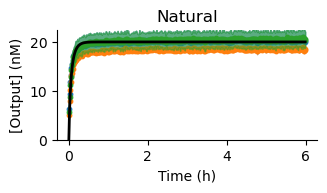

In [42]:
t = t_UW_casc_controls
data = UW_casc_controls[0:number_of_points]
conditions = conditions_UW_casc_controls
levels = list(conditions.keys())
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]





# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]
#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]

# Perform jackknife fitting
res = []
for curve in to_fit[0]:
  res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]

kf_mean = np.mean(res)
n = len(res)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
fitted_kf = kf_mean
param_sd_kf = kf_se


UW_k_control_nat = [[fitted_kf,param_sd_kf]]

# Plotting results
fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_th,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_th,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_th,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)

# Calculating mean normalized RMSE for the condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")



ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

plt.savefig("Figures/UW_casc_control_nat.svg", dpi=400)
plt.show()



Fitted kf = 4.6e+05 ± 3.4e+05 (jackknife SE)
RMSE = 1.792e-09
nRMSE (normed by mean)  = 0.095


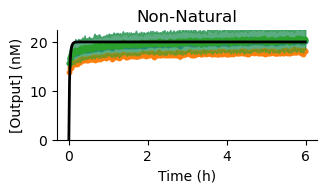

In [43]:

t = t_UW_casc_controls
data = UW_casc_controls[0:number_of_points]
conditions = conditions_UW_casc_controls
levels = list(conditions.keys())
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]





# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

# Initial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]

# Perform jackknife fitting
res = []
for curve in to_fit[0]:
  res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]

kf_mean = np.mean(res)
n = len(res)
kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
fitted_kf = kf_mean
param_sd_kf = kf_se


UW_k_control_nn = [[fitted_kf,param_sd_kf]]

# Plotting results
fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_th,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_th,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_th,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x_h,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)

# Calculating mean normalized RMSE for the condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")



ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Non-Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

plt.savefig("Figures/UW_casc_control_nn.svg", dpi=400)
plt.show()



## With background

### No incubation


#### Natural

Fitted kf = 1.1e+03 ± 1.6e+02 (jackknife SE)
RMSE = 1.156e-09
nRMSE (normed by mean)  = 0.199


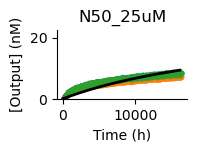

In [44]:
labels = ['N50_25uM']
data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

#intial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]



# Plotting results
fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nat = []
for i,a in enumerate([ax]):
    
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    
# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

plt.savefig('Figures/UW_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



#### NN

Fitted kf = 5.9e+03 ± 1.5e+03 (jackknife SE)
RMSE = 2.757e-09
nRMSE (normed by mean)  = 0.203


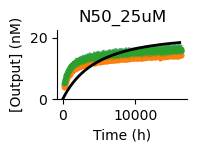

In [45]:
labels = ['N50_25uM']
data = UW_no[0:number_of_points]
conditions = conditions_UW_no
levels = list(conditions.keys())
offset = offset_UW_no
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_UW_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

#intial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]



# Plotting results
fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_no_nn = []
for i,a in enumerate([ax]):
    
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_no_nn.append([fitted_kf,param_sd_kf])
    a.plot(x,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    
# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

plt.savefig('Figures/UW_nn_noinc.svg', dpi = 500, transparent=True)
plt.show()


### Trig incubated

#### NAt

Fitted kf = 8.8e+02 ± 1.4e+02 (jackknife SE)
RMSE = 7.546e-10
nRMSE (normed by mean)  = 0.158


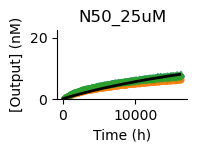

In [46]:
labels = ['N50_25uM']
data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

#intial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]



# Plotting results
fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nat = []
for i,a in enumerate([ax]):
    
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_trig_nat.append([fitted_kf,param_sd_kf])
    a.plot(x,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    
# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

plt.savefig('Figures/UW_nat_trig.svg', dpi = 500, transparent=True)
plt.show()



#### NN

Fitted kf = 4.0e+03 ± 6.0e+02 (jackknife SE)
RMSE = 2.156e-09
nRMSE (normed by mean)  = 0.181


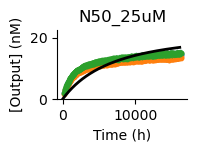

In [47]:
labels = ['N50_25uM']
data = UW_trig[0:number_of_points]
conditions = conditions_UW_trig
levels = list(conditions.keys())
offset = offset_UW_trig
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_UW_trig[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

#intial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]



# Plotting results
fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_trig_nn = []
for i,a in enumerate([ax]):
    
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_trig_nn.append([fitted_kf,param_sd_kf])
    a.plot(x,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    
# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

plt.savefig('Figures/UW_nn_trig.svg', dpi = 500, transparent=True)
plt.show()



### Cascade incubated

#### Natural

Fitted kf = 1.3e+03 ± 2.1e+02 (jackknife SE)
RMSE = 1.285e-09
nRMSE (normed by mean)  = 0.195


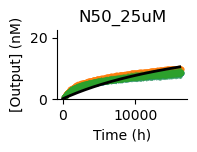

In [48]:
labels = ['N50_25uM']
data = UW_casc[0:number_of_points]
conditions = conditions_UW_casc
levels = list(conditions.keys())
offset = offset_UW_casc
fit = fit_nat
start = time_to_seconds("0:00:00")
x = np.array(t_UW_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [0]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]

#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

#intial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]



# Plotting results
fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nat = []
for i,a in enumerate([ax]):
    
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_rep_nat.append([fitted_kf,param_sd_kf])
    a.plot(x,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    
# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

plt.savefig('Figures/UW_nat_casc.svg', dpi = 500, transparent=True)
plt.show()



### NN

Fitted kf = 1.7e+04 ± 7.5e+03 (jackknife SE)
RMSE = 1.811e-09
nRMSE (normed by mean)  = 0.107


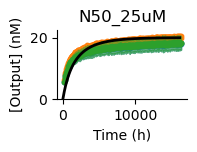

In [49]:
labels = ['N50_25uM']
data = UW_casc[0:number_of_points]
conditions = conditions_UW_casc
levels = list(conditions.keys())
offset = offset_UW_casc
fit = fit_nn
start = time_to_seconds("0:00:00")
x = np.array(t_UW_casc[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, level in enumerate(levels):
    if i in [1]:
      curves += [[get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[1]]]]
      stdDev += [get_triplicates_jackknife(start, offset, level, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]

# Convert time from seconds to hours for plotting
x_th = [x/3600 for x in x_trunc]
x_h = [x/3600 for x in x]



# Initial parameters
y_init = [
    0.0,  # Initial concentration of P   (0)
    20.0,  # Initial concentration of Y1  (1)
    0.0,  # Initial concentration of W   (2)
]
#Reporter concentration in nM
scale = 40


# Fixed parameters for fitting
fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]

#intial guess for fitted k
initial_k = 2e1

# List of time series for fitting
x_list  = [x_trunc]



# Plotting results
fig, ax = plt.subplots(1,1, figsize = (6.5/4,1.25))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2

UW_k_rep_nn = []
for i,a in enumerate([ax]):
    
    # Perform jackknife fitting and plot each replicate
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        res += [fit_model(model_one_step, x_list, [curve], initial_k, fixed_params_list)[0]]


        a.scatter(x_trunc,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    kf_mean = np.mean(res)
    n = len(res)
    kf_se = np.sqrt((n - 1) / n * np.sum((res - kf_mean)**2))

    print(f"Fitted kf = {kf_mean:.1e} ± {kf_se:.1e} (jackknife SE)")
    fitted_kf = kf_mean
    param_sd_kf = kf_se


    UW_k_rep_nn.append([fitted_kf,param_sd_kf])
    a.plot(x,[i*1e9 for i in model_one_step(fitted_kf, x, fixed_params_list[i])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
    
# Calculating mean normalized RMSE for each condition
nrep = len(to_fit[0])
t_i = [x_trunc] * nrep
fixed_i = [fixed_params_list[0]] * nrep   # replicate the dict for each curve
r = residuals(kf_mean, model_one_step, t_i, to_fit[0], fixed_i)
RMSE = np.sqrt(np.mean(r**2))
y_all = np.concatenate(to_fit[0])
nRMSE_mean  = RMSE / y_all.mean()
print(f"RMSE = {RMSE:.3e}")
print(f"nRMSE (normed by mean)  = {nRMSE_mean:.3f}")
ax.get_yaxis().set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylim(0,22.5)

ax.set_ylabel('[Output] (nM)')

plt.savefig('Figures/UW_nn_casc.svg', dpi = 500, transparent=True)
plt.show()



# Comparing TUM and UW Data

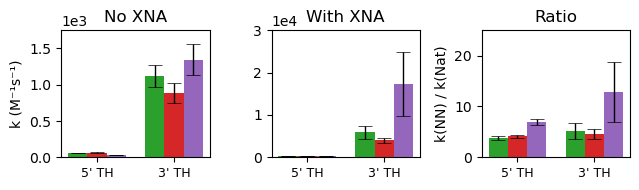


(Within-system) Wald tests: incubation comparisons within each system 

System 5':
No vs Trigger: diff= 0.254 ± 0.433, Z= 0.586, p=5.580e-01, p_holm=5.580e-01
No vs Reporter: diff= 3.034 ± 0.721, Z= 4.209, p=2.570e-05, p_holm=5.140e-05

System 3':
No vs Trigger: diff=-0.741 ± 1.832, Z=-0.404, p=6.860e-01, p_holm=6.860e-01
No vs Reporter: diff= 7.627 ± 6.152, Z= 1.240, p=2.151e-01, p_holm=4.302e-01

(Between-system) Wald tests: 5' vs 3' for each incubation
No incubation    : diff=-1.381 ± 1.597, Z=-0.865, p=3.872e-01, p_holm=9.547e-01
Trigger incubated: diff=-0.386 ± 0.997, Z=-0.388, p=6.982e-01, p_holm=9.547e-01
Reporter incubated: diff=-5.973 ± 5.985, Z=-0.998, p=3.182e-01, p_holm=9.547e-01


In [50]:
# Summary bar plot of all fitted rate constants
fig, ax = plt.subplots(1, 3, sharey=False)
fig.set_figwidth(6.5)
fig.set_figheight(2)

labels = ["5' TH", "3' TH"]
x = np.arange(len(labels))
bar_width = 0.25

# Data assembly for the three panels

# Panel 0: No incubation
no_nat_data_together = [k_no_nat[3],      UW_k_no_nat[0]]
no_nn_data_together  = [k_no_nn[3],       UW_k_no_nn[0]]
no_R_data_together   = [
    [k_no_nn[3][0]      / k_no_nat[3][0],      prop_err_division(k_no_nn[3],      k_no_nat[3])],
    [UW_k_no_nn[0][0]   / UW_k_no_nat[0][0],   prop_err_division(UW_k_no_nn[0],   UW_k_no_nat[0])]
]

# Panel 1: Trigger incubated
trig_nat_data_together = [k_trig_nat[3],   UW_k_trig_nat[0]]
trig_nn_data_together  = [k_trig_nn[3],    UW_k_trig_nn[0]]
trig_R_data_together   = [
    [k_trig_nn[3][0]    / k_trig_nat[3][0],    prop_err_division(k_trig_nn[3],    k_trig_nat[3])],
    [UW_k_trig_nn[0][0] / UW_k_trig_nat[0][0], prop_err_division(UW_k_trig_nn[0], UW_k_trig_nat[0])]
]

# Panel 2: Reporter incubated
rep_nat_data_together = [k_rep_nat[3],     UW_k_rep_nat[0]]
rep_nn_data_together  = [k_rep_nn[3],      UW_k_rep_nn[0]]
rep_R_data_together   = [
    [k_rep_nn[3][0]     / k_rep_nat[3][0],     prop_err_division(k_rep_nn[3],     k_rep_nat[3])],
    [UW_k_rep_nn[0][0]  / UW_k_rep_nat[0][0],  prop_err_division(UW_k_rep_nn[0],  UW_k_rep_nat[0])]
]

# Grouped data for each condition and panel
datasets_panel0 = [
    (no_nat_data_together,   color_scheme[2], -bar_width),
    (trig_nat_data_together, color_scheme[3],  0),
    (rep_nat_data_together,  color_scheme[4],  bar_width),
]
datasets_panel1 = [
    (no_nn_data_together,    color_scheme[2], -bar_width),
    (trig_nn_data_together,  color_scheme[3],  0),
    (rep_nn_data_together,   color_scheme[4],  bar_width),
]
datasets_panel2 = [
    (no_R_data_together,     color_scheme[2], -bar_width),
    (trig_R_data_together,   color_scheme[3],  0),
    (rep_R_data_together,    color_scheme[4],  bar_width),
]

error_params = dict(ecolor='black', lw=1, capsize=5, capthick=0.5)

# Plot panels
# Panel 0: nat
for data_list, color, dx in datasets_panel0:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Panel 1: nn
for data_list, color, dx in datasets_panel1:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Panel 2: ratios
for data_list, color, dx in datasets_panel2:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[2].bar(x + dx, y, width=bar_width, yerr=e, color=color,
              error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=9)
    a.set_ylim(0, 25)
    a.tick_params(axis='x')

ax[0].set_ylabel('k (M⁻¹s⁻¹)', fontsize=10)
ax[2].set_ylabel('k(NN) / k(Nat)', fontsize=10)

ax[0].set_ylim(0, 1750)
ax[1].set_ylim(0, 30000)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Ratio', fontsize=12)

ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 

plt.tight_layout()
plt.savefig('Figures/NAR_cascade_compare_k.svg', dpi=400)
plt.show()

# Statistical analysis of rate constant ratios
# Each block: [ [ratio_5p, se_5p], [ratio_3p, se_3p] ]
ratio_blocks = [no_R_data_together, trig_R_data_together, rep_R_data_together]
incubations = ['No incubation', 'Trigger incubated', 'Reporter incubated']

# Convenience: ratios per system
ratios_5 = [block[0] for block in ratio_blocks]  # 5′ system
ratios_3 = [block[1] for block in ratio_blocks]  # 3′ system

# (2) Within each system: No vs Trigger, No vs Reporter
print("\n(Within-system) Wald tests: incubation comparisons within each system ")

for sys_label, ratio_list in zip(["5'", "3'"], [ratios_5, ratios_3]):
    print(f"\nSystem {sys_label}:")
    comparisons = [
        (0, 1, 'No vs Trigger'),
        (0, 2, 'No vs Reporter'),
    ]
    pvals = []
    rows  = []
    for i1, i2, label in comparisons:
        r1, se1 = ratio_list[i1]
        r2, se2 = ratio_list[i2]
        diff = r2 - r1
        se_diff = np.sqrt(se1**2 + se2**2)
        Z, p = wald_z(diff, se_diff)
        pvals.append(p)
        rows.append((label, diff, se_diff, Z, p))
    p_adj = holm_correction(pvals)
    for (label, diff, se_diff, Z, p_raw), p_corr in zip(rows, p_adj):
        print(f"{label:13s}: diff={diff:6.3f} ± {se_diff:5.3f}, "
              f"Z={Z:6.3f}, p={p_raw:8.3e}, p_holm={p_corr:8.3e}")

# (3) Between systems: 5' vs 3' for each incubation
print("\n(Between-system) Wald tests: 5' vs 3' for each incubation")

pvals_sys = []
results_sys = []
for cond, (r5, se5), (r3, se3) in zip(incubations, ratios_5, ratios_3):
    diff = r5 - r3
    se_diff = np.sqrt(se5**2 + se3**2)
    Z, p = wald_z(diff, se_diff)
    pvals_sys.append(p)
    results_sys.append((cond, diff, se_diff, Z, p))

p_adj_sys = holm_correction(pvals_sys)

for (cond, diff, se_diff, Z, p_raw), p_corr in zip(results_sys, p_adj_sys):
    print(f"{cond:17s}: diff={diff:6.3f} ± {se_diff:5.3f}, "
          f"Z={Z:6.3f}, p={p_raw:8.3e}, p_holm={p_corr:8.3e}")
